In [1]:
# imports and setup
%load_ext autoreload
%autoreload 2
%cd '/home/naodell/work/hgcal/analysis'

/home/naodell/work/hgcal/analysis


In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from sklearn import preprocessing
import seaborn as sns
from tqdm.notebook import tqdm, trange

from models.autoencoder import AutoEncoderModular
from models.loss import mse_loss_regularized
from datasets.hgcal_tc_dataset import HGCalTCModuleDictDataset

#%connect_info

In [3]:
# get the data
input_dir = 'local_data/econ_training_data/single_photon_data/'
input_filenames = [f'{input_dir}/{f}' for f in os.listdir(input_dir)]
hgcal_data = HGCalTCModuleDictDataset(input_filenames)

# sample from dataframe according to event weights; split into testing and training sets
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# training sample
batch_size = 8
n_total = len(hgcal_data)
split = round(0.8*n_total)
train_loader = DataLoader(hgcal_data[:split],  batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(hgcal_data[split:],  batch_size=batch_size, shuffle=True, pin_memory=True)
print(f'Total number of events: {n_total}')

Total number of events: 27099


In [4]:
# define and setup the NN model
scenario = 'modular'
model = AutoEncoderModular().to(device)
print(device, model, sep='\n')

cuda
AutoEncoderModular(
  (encoder): ModuleDict(
    (0): WaferEncoder(
      (conv2d): Conv2d(14, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=14, bias=False)
      (act_conv): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dense_layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=128, out_features=8, bias=True)
          (1): ReLU()
        )
        (1): Sequential(
          (0): Linear(in_features=128, out_features=8, bias=True)
          (1): ReLU()
        )
        (2): Sequential(
          (0): Linear(in_features=128, out_features=8, bias=True)
          (1): ReLU()
        )
        (3): Sequential(
          (0): Linear(in_features=128, out_features=8, bias=True)
          (1): ReLU()
        )
        (4): Sequential(
          (0): Linear(in_features=128, out_features=8, bias=True)
          (1): ReLU()
        )
        (5): Sequential(
          (0): Linear(in_features

In [5]:
# optimize NN weights
n_epochs = 100
n_events = len(train_loader)

# define loss and configure optimizer
loss_fn = nn.HuberLoss(reduction='sum')
#loss_fn = mse_loss_regularized

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
tb_writer = SummaryWriter(log_dir='logs')

pbar1 = tqdm(range(n_epochs), total=n_epochs, leave=False, position=0)
pbar1.set_postfix({'avg. loss':'?'})
loss_cache = []
for iepoch in pbar1:
    model.train()
    pbar2 = tqdm(train_loader, total=n_events, leave=False, position=1)
    pbar2.set_postfix({'loss':'?'})
    avg_loss = 0
    for jevent, (features, keys) in enumerate(pbar2):
        #features = features.unsqueeze(1).to(device)
        features = features.to(device)
        #targets = targets.to(device)
        optimizer.zero_grad()
        features_pred = model(features, keys)
        loss = loss_fn(torch.log(1. + features_pred), torch.log(1. + features))
        loss.backward()
        optimizer.step()
        
        #pbar2.set_postfix({'loss':f'{loss.item():.3f}'})
        #tb_writer.add_scalar('training loss', loss.item(), iepoch*n_events + jevent)
        
        avg_loss += loss.item()
        if jevent%10 == 0:
            avg_loss /= 10
            pbar2.set_postfix({'loss':f'{loss.item():.3f}'})
            tb_writer.add_scalar('training loss', loss.item(), iepoch*(n_events//10) + jevent/10)
            avg_loss = 0
        
    with torch.no_grad():
        model.eval()
        test_loss = 0
        n_test_events = len(test_loader)
        for features, keys in tqdm(test_loader, total=n_test_events, leave=False):
            features = features.to(device)
            #targets = targets.to(device)
            features_pred = model(features, keys)
            #tqdm.write(features_pred.shape, features.shape)
            test_loss += loss_fn(torch.log(1. + features_pred), torch.log(1. + features))
            loss_cache.append(test_loss.item())
            
            
        avg_loss = test_loss.item()/n_test_events
        pbar1.set_postfix({'avg loss':f'{avg_loss:.3f}'})
        tb_writer.add_scalar('test loss', avg_loss, iepoch)
        #tb_writer.add_graph(model, features)
        
        #images = torchvision.utils.make_grid(features)
        #images_pred = torchvision.utils.make_grid(features_pred)
        #tb_writer.add_image('input', images)
        #tb_writer.add_image('output', images_pred)
        
        # write a checkpoint based on the performance of the model



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

  0%|          | 0/2710 [00:00<?, ?it/s]

  0%|          | 0/678 [00:00<?, ?it/s]

In [19]:
# compare images
import utils.plot_tools as pt
from matplotlib.colors import LogNorm

with torch.no_grad():
    model.eval()
    
    images, keys = iter(test_loader).next()
    # batch_size = 8, n_layers = 14, 8, 8
    images = images.to(device)
    images_pred = model(images, keys)
    images_enc = [model.encode(images[i], f'{k}') for i, k in enumerate(keys)]
    for ibatch, key in enumerate(keys):
        image_data = zip(images[ibatch], images_pred[ibatch], images_enc[ibatch])
        fig, axes = plt.subplots(3, 14, facecolor='white', figsize=(14, 6), sharey=False, sharex=False)
        emax = images[ibatch].max()
        for ilayer, (image, image_pred, encoded_image) in enumerate(image_data):
            image = image.squeeze().cpu().numpy()
            encoded_image = encoded_image.squeeze().cpu().numpy()
            image_pred = image_pred.squeeze().cpu().numpy().reshape(image.shape)
            #energy_corr = image.sum()/image_pred.sum()
            #image_pred *= energy_corr

            ax = axes[0][ilayer]
            #ax.set_aspect('equal')
            pt.draw_single_module_pixels(ax, cell_data=image, no_axes=True)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'layer {ilayer}', fontsize=8)
            if ilayer == 0:
                ax.set_ylabel('input', fontsize=8)

            ax = axes[1][ilayer]
            #ax.set_aspect('equal')
            ax.pcolor(encoded_image.reshape(-1, 2), vmin=0.)
            ax.set_xticks([])
            ax.set_yticks([])
            if ilayer == 0:
                ax.set_ylabel('encoded', fontsize=8)
#
            ax = axes[2][ilayer]
            #ax.set_aspect('equal')
            pt.draw_single_module_pixels(ax, cell_data=image_pred, no_axes=True)
            #ax.imshow(image_pred, norm=LogNorm())
            ax.set_xticks([])
            ax.set_yticks([])
            if ilayer == 0:
                ax.set_ylabel('output', fontsize=8)
        
        
        plt.tight_layout()
        plt.savefig(f'plots/{scenario}/ae_encoding_comparisons_{ibatch}.png')
        plt.close()
        #plt.show()

In [37]:
# Plot the the total error for both total energy and 
energy_sums = []
energy_sums_pred = []
energy_diffs = []
        
with torch.no_grad():
    model.eval()
    test_loss = 0
    n_test_events = len(test_loader)
    for features, keys in tqdm(test_loader, total=n_test_events, leave=False):
        features = features.to(device)
        #targets = targets.to(device)
        features_pred = model(features, keys)
        
        features = features.cpu().numpy()
        features_pred = features_pred.cpu().numpy()
        esums = features.sum(axis=(-1, -2))
        esums_pred = features_pred.sum(axis=(-1, -2))
        
        energy_sums.append(esums)
        energy_sums_pred.append(esums_pred)
        energy_diffs.append(esums_pred - esums)
        

energy_diffs = np.concatenate(energy_diffs).flatten()
energy_sums = np.concatenate(energy_sums).flatten()
energy_sums_pred = np.concatenate(energy_sums_pred).flatten()

mask = (energy_sums > 0.) & (energy_sums_pred > 0)
energy_sums = energy_sums[mask]
energy_diffs = energy_diffs[mask]

  0%|          | 0/678 [00:00<?, ?it/s]

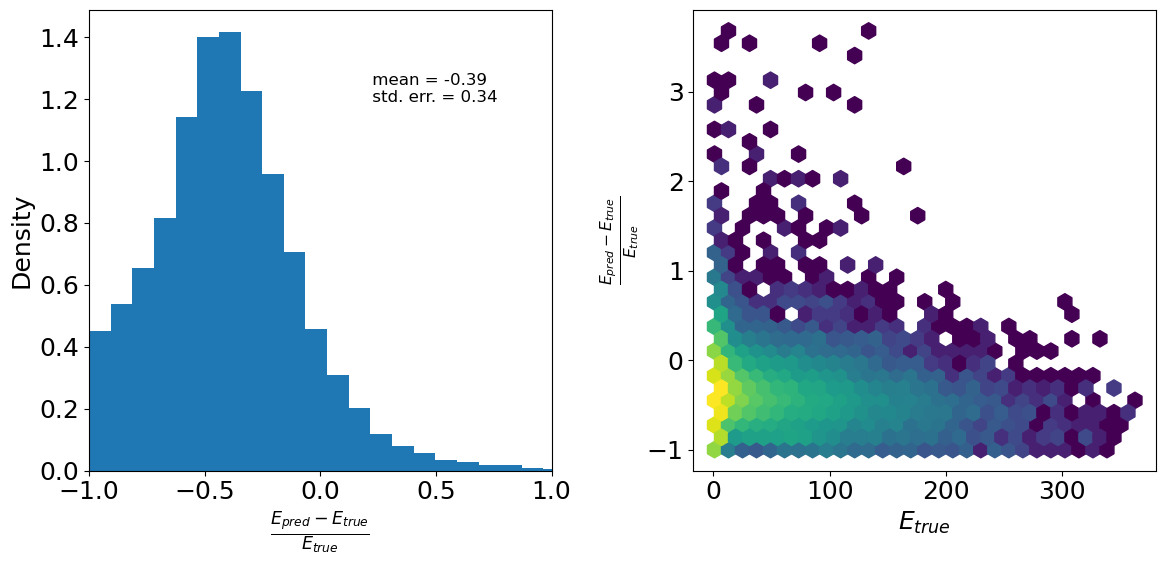

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
frac_energy_diff = energy_diffs/energy_sums
ax.hist(frac_energy_diff, bins=50, density=True)
ax.set_xlabel(r'$\frac{E_{pred} - E_{true}}{E_{true}}$')
ax.set_ylabel('Density')
ax.text(0.6, 0.8, f' mean = {frac_energy_diff.mean():.2f} \n std. err. = {frac_energy_diff.std():.2f}', fontsize=12, transform=ax.transAxes)

ax.set_xlim(-1, 1)

ax = axes[1]
ax.hexbin(energy_sums, frac_energy_diff, gridsize=30, mincnt=1, norm=LogNorm())
ax.set_ylabel(r'$\frac{E_{pred} - E_{true}}{E_{true}}$', size=16)
ax.set_xlabel(r'$E_{true}$')

plt.tight_layout()
plt.savefig(f'plots/ae_energy_resolution_{scenario}.png')
plt.show()